In [1]:
# Python 3
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from bs4 import BeautifulSoup

import unicodedata as uni
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from string import punctuation


pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

%matplotlib inline

//anaconda/envs/capstone/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Goal: 
Using   the   training   data   in    ages_train.csv ,   build   a   statistical   model   to   predict   the
age   of   users   in    ages_test.csv,     based   on   any   of   the   information   provided   (profiles, friend   networks,   and   mentions).

# Load data

In [2]:
# load json files: 
ap = pd.read_json('assignment_package/age_profiles.json')
at = pd.read_json('assignment_package/age_tweets.json')

In [3]:
# load csv files:
ages_train = pd.read_csv('assignment_package/ages_train.csv')
mentions = pd.read_csv('assignment_package/mentions.csv')
friends = pd.read_csv('assignment_package/friends.csv')

# Take a look at data

In [4]:
mentions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17695 entries, 0 to 17694
Data columns (total 3 columns):
ID                 17695 non-null int64
MentionedID        17695 non-null int64
MentionedHandle    17695 non-null object
dtypes: int64(2), object(1)
memory usage: 414.8+ KB


In [5]:
mentions.head()

,ID,MentionedID,MentionedHandle
0,612815277,798747864,AlenaBacalia
1,612815277,354590068,hfholden34
2,612815277,401111769,MarilynYousif
3,612815277,35581752,heeeeyerin
4,612815277,1591956090,DogeTheDog


In [6]:
friends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46609 entries, 0 to 46608
Data columns (total 2 columns):
ID          46609 non-null int64
FriendID    46609 non-null int64
dtypes: int64(2)
memory usage: 728.3 KB


In [7]:
friends.head()

,ID,FriendID
0,612815277,574147452
1,612815277,36767299
2,612815277,29374598
3,612815277,67634814
4,612815277,30008146


In [8]:
ages_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 2 columns):
ID     1711 non-null int64
Age    1711 non-null int64
dtypes: int64(2)
memory usage: 26.8 KB


In [9]:
ages_train.head()

,ID,Age
0,23605717,21
1,781084760,19
2,102262916,21
3,413710015,21
4,584304916,90


In [10]:
ap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2410 entries, 0 to 2409
Data columns (total 41 columns):
contributors_enabled                  2410 non-null bool
created_at                            2410 non-null datetime64[ns]
default_profile                       2410 non-null bool
default_profile_image                 2410 non-null bool
description                           2410 non-null object
entities                              2410 non-null object
favourites_count                      2410 non-null int64
follow_request_sent                   2410 non-null bool
followers_count                       2410 non-null int64
following                             2410 non-null bool
friends_count                         2410 non-null int64
geo_enabled                           2410 non-null bool
id                                    2410 non-null int64
id_str                                2410 non-null int64
is_translation_enabled                2410 non-null bool
is_translator      

In [11]:
ap.head()

,contributors_enabled,created_at,default_profile,default_profile_image,description,entities,favourites_count,follow_request_sent,followers_count,following,friends_count,geo_enabled,id,id_str,is_translation_enabled,is_translator,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,protected,screen_name,status,statuses_count,time_zone,url,utc_offset,verified
0,False,2012-06-19 17:54:58,False,False,You'll never find another one like me.,{'description': {'urls': []}},7931,False,274,False,264,True,612815277,612815277,False,False,en,1,,Greggy,False,131516,http://abs.twimg.com/images/themes/theme14/bg.gif,https://abs.twimg.com/images/themes/theme14/bg...,True,https://pbs.twimg.com/profile_banners/61281527...,http://pbs.twimg.com/profile_images/4776662828...,https://pbs.twimg.com/profile_images/477666282...,009999,EEEEEE,EFEFEF,333333,True,False,agregtoremember,"{'retweeted_status': {'retweet_count': 452, 'c...",12230,Atlantic Time (Canada),None,-10800.0,False
1,False,2012-02-12 22:36:17,False,False,"If you like me, i probably like you more. {IG:...",{'description': {'urls': []}},1141,False,481,False,527,True,490791079,490791079,False,False,en,1,9⃣3⃣7⃣,Guff✌️,False,1A1B1F,http://abs.twimg.com/images/themes/theme9/bg.gif,https://abs.twimg.com/images/themes/theme9/bg.gif,False,https://pbs.twimg.com/profile_banners/49079107...,http://pbs.twimg.com/profile_images/5097227545...,https://pbs.twimg.com/profile_images/509722754...,2FC2EF,181A1E,252429,666666,True,False,C_Guffieee,"{'retweet_count': 0, 'created_at': 'Fri Sep 26...",14680,Hawaii,None,-36000.0,False
2,False,2011-03-11 21:44:56,False,False,Success doesn’t come to you…you go to it.,{'description': {'urls': []}},174,False,878,False,953,False,264416315,264416315,False,False,en,2,Wonderland,Starqueria.⚓,False,FCEBB6,http://pbs.twimg.com/profile_background_images...,https://pbs.twimg.com/profile_background_image...,True,https://pbs.twimg.com/profile_banners/26441631...,http://pbs.twimg.com/profile_images/5127311352...,https://pbs.twimg.com/profile_images/512731135...,CE7834,F0A830,78C0A8,5E412F,True,False,_Starqueria,"{'retweeted_status': {'retweet_count': 2614, '...",22857,Hawaii,None,-36000.0,False
3,False,2009-12-17 20:08:55,False,False,NEVER care about what a person says that doesn...,{'description': {'urls': []}},303,False,742,False,701,False,97515432,97515432,False,False,en,30,•Carolina South• 843•,. keeleesha,False,131516,http://pbs.twimg.com/profile_background_images...,https://pbs.twimg.com/profile_background_image...,True,NaN,http://pbs.twimg.com/profile_images/4939742059...,https://pbs.twimg.com/profile_images/493974205...,009999,FFFFFF,EFEFEF,333333,True,False,Keeleesha,"{'retweet_count': 0, 'entities': {'urls': [], ...",71654,Eastern Time (US & Canada),None,-14400.0,False
4,False,2011-03-24 21:14:53,False,False,these niggas some haters & i made myself so ea...,{'description': {'urls': []}},52,False,729,False,688,False,271608323,271608323,False,False,en,0,Seven•five•Seven,killakee :),False,0A0A0A,http://pbs.twimg.com/profile_background_images...,https://pbs.twimg.com/profile_background_image...,True,https://pbs.twimg.com/profile_banners/27160832...,http://pbs.twimg.com/profile_images/4627093362...,https://pbs.twimg.com/profile_images/462709336...,D62D0F,000000,000000,A3A3A3,True,False,KeeLashawn_,"{'retweet_count': 0, 'entities': {'urls': [{'e...",48452,Eastern Time (US & Canada),None,-14400.0,False


In [12]:
at.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28138 entries, 0 to 28137
Data columns (total 25 columns):
contributors                 0 non-null float64
coordinates                  1298 non-null object
created_at                   28138 non-null datetime64[ns]
entities                     28138 non-null object
favorite_count               28138 non-null int64
favorited                    28138 non-null bool
geo                          1298 non-null object
id                           28138 non-null int64
id_str                       28138 non-null int64
in_reply_to_screen_name      5299 non-null object
in_reply_to_status_id        4839 non-null float64
in_reply_to_status_id_str    4839 non-null float64
in_reply_to_user_id          5299 non-null float64
in_reply_to_user_id_str      5299 non-null float64
lang                         28138 non-null object
metadata                     28138 non-null object
place                        1341 non-null object
possibly_sensitive          

In [13]:
at.head()

,contributors,coordinates,created_at,entities,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,metadata,place,possibly_sensitive,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,NaN,None,2014-09-26 05:55:45,"{'hashtags': [], 'urls': [], 'symbols': [], 'u...",0,False,None,515379174454747136,515379174454747136,None,NaN,NaN,NaN,NaN,en,"{'result_type': 'recent', 'iso_language_code':...",None,NaN,7,False,"{'in_reply_to_status_id': None, 'coordinates':...","<a href=""http://twitter.com/download/iphone"" r...",RT @AlenaBacalia: i over think and second gues...,False,"{'follow_request_sent': False, 'profile_image_..."
1,NaN,None,2014-09-26 05:58:17,"{'hashtags': [], 'urls': [], 'symbols': [], 'u...",0,False,None,515379813670854656,515379813670854656,None,NaN,NaN,NaN,NaN,en,"{'result_type': 'recent', 'iso_language_code':...",None,NaN,80,False,"{'in_reply_to_status_id': None, 'coordinates':...","<a href=""http://twitter.com/download/iphone"" r...",RT @hfholden34: I've wasted too much time on t...,False,"{'follow_request_sent': False, 'profile_image_..."
2,NaN,None,2014-09-26 05:59:47,"{'hashtags': [], 'urls': [], 'symbols': [], 'u...",1,False,None,515380190361288704,515380190361288704,None,NaN,NaN,NaN,NaN,en,"{'result_type': 'recent', 'iso_language_code':...",None,NaN,1,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",I'm already gone.,False,"{'follow_request_sent': False, 'profile_image_..."
3,NaN,None,2014-09-26 06:00:07,"{'hashtags': [], 'urls': [], 'symbols': [], 'u...",1,False,None,515380273005854721,515380273005854720,None,NaN,NaN,NaN,NaN,en,"{'result_type': 'recent', 'iso_language_code':...",None,NaN,0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",I'm already something to someone that I don't ...,False,"{'follow_request_sent': False, 'profile_image_..."
4,NaN,None,2014-09-26 08:09:57,"{'hashtags': [], 'urls': [], 'symbols': [], 'u...",1,False,None,515412946608852992,515412946608852992,None,NaN,NaN,NaN,NaN,en,"{'result_type': 'recent', 'iso_language_code':...",None,NaN,0,False,NaN,"<a href=""http://twitter.com/download/android"" ...","I don't know what I'm doing with my life, but ...",False,"{'follow_request_sent': False, 'profile_image_..."


# First Iteration: Use all numeric variables to fit a linear regression model

In [14]:
def extract_emojis(s):
    return ''.join(c for c in str(s) if c in emoji.UNICODE_EMOJI)

def age_profiles_prep(age_profiles):
    '''Process age_profiles for modeling'''
    ap_new = pd.concat([age_profiles,
                        pd.DataFrame(age_profiles['status'].apply(pd.Series) \
                        .rename(columns = lambda x: 'status_' + str(x)))], axis=1)
    ap_new['status_emoji'] = ap_new['status_text'].map(lambda x: extract_emojis(x))
    ap_new['has_emoji'] = ap_new['status_emoji'].map(lambda x: int(x != ''))
    ap_new['emoji_cnt'] = ap_new['status_emoji'].map(lambda x: len(x))
    return ap_new

In [15]:
def joined_age(ap_new, ages_train):
    ap_new = ap_new.set_index('id')
    ages_train = ages_train.set_index('ID')
    age_joined = ap_new.join(ages_train, how='inner')
    return age_joined

In [16]:
ap_new = age_profiles_prep(ap)

//anaconda/envs/capstone/lib/python3.6/site-packages/pandas/core/indexes/api.py:43: RuntimeWarning: '>' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  union = _union_indexes(indexes)
//anaconda/envs/capstone/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: '>' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


In [17]:
ap_new['source_parsed'] = ap_new['status_source'].apply(lambda x: BeautifulSoup(str(x),'html.parser').text)

In [18]:
# define ios devices:
ios = ['Twitter for iPhone', 'Twitter for iPad', 'iOS', 'Twitter for Mac', 'Tweetbot for Mac',
       'TweetCaster for iOS', 'Tweetbot for iΟS', 'Osfoora for iOS', 'UberSocial for iPhone', 'OS X',
       'Instagram on iOS', '8 Ball Pool™ on iOS', 'Photos on iOS']

In [19]:
# define Android devices:
android = ['Twitter for Android', 'TweetCaster for Android', 'Plume for Android',
          'Twitter for Android Tablets', 'Twitter for  Android', 'UberSocial for Android',
          'Vine for Android', 'Fenix for Android', 'Echofon  Android']

In [20]:
# create a new column as source_ios, in order to get proportion
ap_new['source_ios'] = (ap_new['source_parsed'].isin(ios)).astype(int)
ap_new['source_android'] = (ap_new['source_parsed'].isin(android)).astype(int)

In [21]:
age_joined = joined_age(ap_new, ages_train)

#### ages_train dataset has 1711 user IDs, age_profiles has 2410 users IDs, after inner join with age_profiles, return 1688 user IDs.

In [23]:
age_joined.describe()

,favourites_count,followers_count,friends_count,id_str,listed_count,statuses_count,utc_offset,status_contributors,status_favorite_count,status_id,status_in_reply_to_status_id,status_in_reply_to_user_id,status_retweet_count,status_0,has_emoji,emoji_cnt,source_ios,source_android,Age
count,1688.000000,1688.000000,1688.000000,1.688000e+03,1688.000000,1688.00000,1187.000000,0.0,1664.000000,1.664000e+03,2.040000e+02,2.430000e+02,1664.000000,0.0,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000
mean,1769.623223,989.703199,745.468602,6.863965e+08,5.848341,17187.82109,-12522.662174,NaN,0.274038,5.147472e+17,5.147682e+17,6.411431e+08,305.992788,NaN,0.261848,0.592417,0.526066,0.188981,22.214455
std,4048.312684,8096.493864,5913.824414,8.022633e+08,40.450173,25403.11617,15030.538346,NaN,1.026128,2.487937e+15,2.582377e+15,7.675660e+08,2136.013252,NaN,0.439771,2.226049,0.499468,0.391610,7.244988
min,0.000000,0.000000,-69.000000,2.025381e+06,0.000000,0.00000,-39600.000000,NaN,0.000000,4.914759e+17,4.912976e+17,8.771022e+06,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,18.000000
25%,99.750000,160.750000,176.750000,1.442114e+08,0.000000,2080.75000,-18000.000000,NaN,0.000000,5.151386e+17,5.151718e+17,1.424379e+08,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,19.000000
50%,546.000000,347.000000,338.000000,3.384143e+08,1.000000,7746.50000,-18000.000000,NaN,0.000000,5.154432e+17,5.154378e+17,3.309488e+08,0.000000,NaN,0.000000,0.000000,1.000000,0.000000,21.000000
75%,1880.250000,702.250000,614.250000,8.548117e+08,3.000000,21482.75000,-10800.000000,NaN,0.000000,5.155501e+17,5.155525e+17,8.055676e+08,1.000000,NaN,1.000000,1.000000,1.000000,0.000000,22.000000
max,99169.000000,258937.000000,202293.000000,2.832494e+09,1292.000000,257590.00000,43200.000000,NaN,23.000000,5.155829e+17,5.155821e+17,2.785766e+09,40111.000000,NaN,1.000000,74.000000,1.000000,1.000000,111.000000


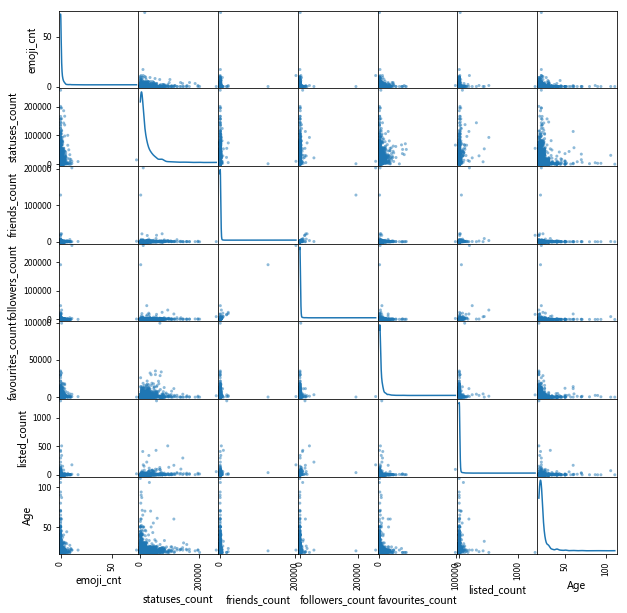

In [24]:
scatter_matrix(age_joined[['emoji_cnt','statuses_count','friends_count','followers_count',
                        'favourites_count','listed_count','Age']], alpha=.5, figsize=(10, 10), diagonal='kde');

In [25]:
# Length of user profile description?
age_joined['description_length'] = age_joined['description'].apply(lambda x: len(x))

-  length of description seems not that different across age

- How user identify location might have signal. (Natural language processing). But hard to extract in a short period of time.

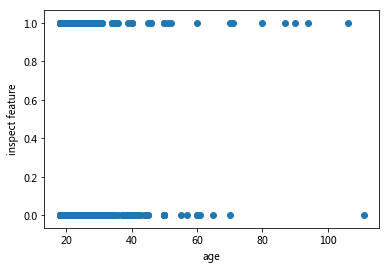

In [26]:
# profile_background_tile: seems not that different across ages
plt.scatter(age_joined['Age'], age_joined['profile_background_tile'])
plt.xlabel('age')
plt.ylabel('inspect feature')

In [27]:
age_joined['profile_use_background_image'].value_counts()

True     1584
False     104
Name: profile_use_background_image, dtype: int64

In [28]:
age_joined['protected'].value_counts()

False    1665
True       23
Name: protected, dtype: int64

In [29]:
age_joined['source_parsed'] = age_joined['status_source'].apply(lambda x: BeautifulSoup(str(x),'html.parser').text)

In [30]:
# create a new column as age_decade:
bins = [17,25,35,45,55,120]
group_names = ['18-25','26-35','36-45','46-55','>55']
age_joined['age_decade'] = pd.cut(age_joined['Age'], bins, labels=group_names)

In [31]:
age_joined.head()

,contributors_enabled,created_at,default_profile,default_profile_image,description,entities,favourites_count,follow_request_sent,followers_count,following,friends_count,geo_enabled,id_str,is_translation_enabled,is_translator,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,protected,screen_name,status,statuses_count,time_zone,url,utc_offset,verified,status_contributors,status_coordinates,status_created_at,status_entities,status_favorite_count,status_favorited,status_geo,status_id,status_id_str,status_in_reply_to_screen_name,status_in_reply_to_status_id,status_in_reply_to_status_id_str,status_in_reply_to_user_id,status_in_reply_to_user_id_str,status_lang,status_place,status_possibly_sensitive,status_retweet_count,status_retweeted,status_retweeted_status,status_source,status_text,status_truncated,status_0,status_emoji,has_emoji,emoji_cnt,source_parsed,source_ios,source_android,Age,description_length,age_decade
612815277,False,2012-06-19 17:54:58,False,False,You'll never find another one like me.,{'description': {'urls': []}},7931,False,274,False,264,True,612815277,False,False,en,1,,Greggy,False,131516,http://abs.twimg.com/images/themes/theme14/bg.gif,https://abs.twimg.com/images/themes/theme14/bg...,True,https://pbs.twimg.com/profile_banners/61281527...,http://pbs.twimg.com/profile_images/4776662828...,https://pbs.twimg.com/profile_images/477666282...,009999,EEEEEE,EFEFEF,333333,True,False,agregtoremember,"{'retweeted_status': {'retweet_count': 452, 'c...",12230,Atlantic Time (Canada),None,-10800.0,False,NaN,None,Fri Sep 26 16:49:37 +0000 2014,"{'urls': [], 'user_mentions': [{'id': 15919560...",0.0,False,None,5.155437e+17,515543724785684480,None,NaN,None,NaN,None,en,None,NaN,452.0,False,"{'retweet_count': 452, 'created_at': 'Fri Sep ...","<a href=""http://twitter.com/download/android"" ...",RT @DogeTheDog: Wow\n So friday\n ...,False,NaN,,0,0,Twitter for Android,0,1,21,38,18-25
490791079,False,2012-02-12 22:36:17,False,False,"If you like me, i probably like you more. {IG:...",{'description': {'urls': []}},1141,False,481,False,527,True,490791079,False,False,en,1,9⃣3⃣7⃣,Guff✌️,False,1A1B1F,http://abs.twimg.com/images/themes/theme9/bg.gif,https://abs.twimg.com/images/themes/theme9/bg.gif,False,https://pbs.twimg.com/profile_banners/49079107...,http://pbs.twimg.com/profile_images/5097227545...,https://pbs.twimg.com/profile_images/509722754...,2FC2EF,181A1E,252429,666666,True,False,C_Guffieee,"{'retweet_count': 0, 'created_at': 'Fri Sep 26...",14680,Hawaii,None,-36000.0,False,NaN,None,Fri Sep 26 17:42:07 +0000 2014,"{'urls': [], 'user_mentions': [], 'symbols': [...",0.0,False,None,5.155569e+17,515556938512609280,None,NaN,None,NaN,None,en,None,NaN,0.0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Damn I gotta wait to next week to get the IPho...,False,NaN,😒,1,1,Twitter for iPhone,1,0,18,56,18-25
264416315,False,2011-03-11 21:44:56,False,False,Success doesn’t come to you…you go to it.,{'description': {'urls': []}},174,False,878,False,953,False,264416315,False,False,en,2,Wonderland,Starqueria.⚓,False,FCEBB6,http://pbs.twimg.com/profile_background_images...,https://pbs.twimg.com/profile_background_image...,True,https://pbs.twimg.com/profile_banners/26441631...,http://pbs.twimg.com/profile_images/5127311352...,https://pbs.twimg.com/profile_images/512731135...,CE7834,F0A830,78C0A8,5E412F,True,False,_Starqueria,"{'retweeted_status': {'retweet_count': 2614, '...",22857,Hawaii,None,-36000.0,False,NaN,None,Fri Sep 26 02:57:32 +0000 2014,"{'urls': [], 'media': [{'media_url': 'http://p...",0.0,False,None,5.153343e+17,515334328113307649,None,NaN,None,NaN,None,en,None,False,2614.0,False,"{'retweet_count': 2614, 'entities': {'urls': [...","<a 

In [32]:
age_joined.groupby('age_decade')['Age'].count()

age_decade
18-25    1488
26-35     136
36-45      36
46-55      13
>55        15
Name: Age, dtype: int64

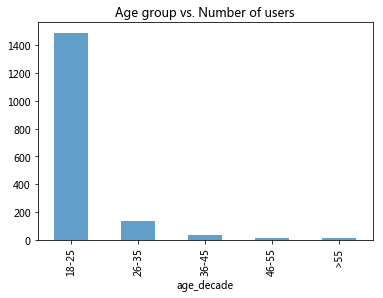

In [33]:
age_joined.groupby('age_decade')['Age'].count().plot(kind='bar',alpha=.7)
plt.title('Age group vs. Number of users')

In [34]:
age_joined.groupby('age_decade')['source_android'].sum()

age_decade
18-25    288
26-35     20
36-45      7
46-55      3
>55        1
Name: source_android, dtype: int64

In [35]:
age_joined.groupby('age_decade')['source_ios'].sum()

age_decade
18-25    800
26-35     61
36-45     14
46-55      3
>55       10
Name: source_ios, dtype: int64

In [36]:
age_joined.groupby('age_decade')['favourites_count'].mean()

age_decade
18-25    1907.367608
26-35     509.897059
36-45     518.194444
46-55    1714.000000
>55      2578.533333
Name: favourites_count, dtype: float64

In [37]:
age_joined.groupby('age_decade')['followers_count'].mean()

age_decade
18-25    1024.581989
26-35     705.338235
36-45     330.305556
46-55     334.230769
>55      2258.600000
Name: followers_count, dtype: float64

## Intital guesses about tweets text:
1. use # or not
2. which # are they using
3. mention people or not
4. who are they mentioning, age of the people they are mentioning
5. use emoji or not
6. how many emojis are they using
7. which emoji are they using -- emoji as categorical variables
8. words in tweets. e.g. TGIF, thank god it's friday, lmao, etc.
9. punctuations in tweets
10. sentiment in tweets

In [38]:
age_joined['is_18_25'] = age_joined['age_decade'].map(lambda x: x == '18-25')

In [39]:
age_joined['is_18_25'].value_counts()
# imbalanced class!

True     1488
False     200
Name: is_18_25, dtype: int64

In [40]:
age_joined['has_description'] = age_joined['description'].map(lambda x: x != '')

In [41]:
age_joined.groupby('is_18_25')['has_description'].sum()/age_joined.groupby('is_18_25')['has_description'].count()
# no signal

is_18_25
False    0.865000
True     0.872312
Name: has_description, dtype: float64

In [42]:
# create 2 dataframes to inspect the difference between the age groups:
old_group = age_joined[age_joined['is_18_25'] == False]
young_group = age_joined[age_joined['is_18_25'] == True]

In [43]:
old_group.head()

,contributors_enabled,created_at,default_profile,default_profile_image,description,entities,favourites_count,follow_request_sent,followers_count,following,friends_count,geo_enabled,id_str,is_translation_enabled,is_translator,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,protected,screen_name,status,statuses_count,time_zone,url,utc_offset,verified,status_contributors,status_coordinates,status_created_at,status_entities,status_favorite_count,status_favorited,status_geo,status_id,status_id_str,status_in_reply_to_screen_name,status_in_reply_to_status_id,status_in_reply_to_status_id_str,status_in_reply_to_user_id,status_in_reply_to_user_id_str,status_lang,status_place,status_possibly_sensitive,status_retweet_count,status_retweeted,status_retweeted_status,status_source,status_text,status_truncated,status_0,status_emoji,has_emoji,emoji_cnt,source_parsed,source_ios,source_android,Age,description_length,age_decade,is_18_25,has_description
40604337,False,2009-05-17 04:03:18,False,False,instagram tyshanna 29,{'description': {'urls': []}},412,False,205,False,230,True,40604337,False,False,en,0,Bronx new York,tyshanna deleston,False,1A1B1F,http://abs.twimg.com/images/themes/theme9/bg.gif,https://abs.twimg.com/images/themes/theme9/bg.gif,False,https://pbs.twimg.com/profile_banners/40604337...,http://pbs.twimg.com/profile_images/4679213711...,https://pbs.twimg.com/profile_images/467921371...,F00C2B,D9B17E,EADEAA,333333,True,False,tyshanna,"{'retweet_count': 0, 'entities': {'urls': [], ...",360,None,None,NaN,False,NaN,None,Sun Sep 21 00:01:47 +0000 2014,"{'urls': [], 'media': [{'media_url': 'http://p...",0.0,False,None,5.134782e+17,513478157870333953,None,NaN,None,NaN,None,und,None,False,0.0,False,NaN,"<a href=""http://twitter.com/download/android"" ...",http://t.co/R9nwkoNriu,False,NaN,,0,0,Twitter for Android,0,1,30,21,26-35,False,True
2718214807,False,2014-08-08 23:24:43,True,False,if today was my birthday i would want a taco b...,"{'description': {'urls': []}, 'url': {'urls': ...",59,False,15,False,93,False,2718214807,False,False,en,0,America,Brian,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/27182148...,http://pbs.twimg.com/profile_images/4978981967...,https://pbs.twimg.com/profile_images/497898196...,0084B4,C0DEED,DDEEF6,333333,True,False,bri_ancausey,"{'retweet_count': 0, 'created_at': 'Wed Sep 24...",137,Central Time (US & Canada),http://t.co/vtwOQkxC2B,-18000.0,False,NaN,None,Wed Sep 24 01:26:43 +0000 2014,"{'urls': [], 'user_mentions': [], 'symbols': [...",0.0,False,None,5.145867e+17,514586695090438144,None,NaN,None,NaN,None,en,None,NaN,0.0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",im devating if i should go to sleep,False,NaN,,0,0,Twitter for iPhone,1,0,33,73,26-35,False,True
559747070,False,2012-04-21 17:49:48,True,False,Jazztronics at Liberty 2011 - Cosmopolitan Pig...,"{'description': {'urls': []}, 'url': {'urls': ...",17,False,14,False,21,True,559747070,False,False,en,0,london forest hill,Wayne Taylor,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/55974707...,http://pbs.twimg.com/profile_images/5144103387...,https://pbs.twimg.com/profile_images/514410338...,0084B4,C0DEED,DDEEF6,333333,True,False,spurswayne,"{'retweet_count': 0, 'entities': {'urls': [{'e...",439,None,http://t.co/r9356Nff7o,NaN,False,NaN,"{'coordinates': [-0.00451232, 51.54273529], 't...",Mon Sep 22 19:26:11 +0000 2014,{'urls': [{'expanded_url': 'http://instagram.c...,0.0,False,"{'coordinates': [51.54273529, -0.00451232], 't...",5.1413

## Get two raw strings, combine all users' tweets in two groups together, find their difference

In [44]:
young_tweet = young_group['status_text'].to_string()

In [45]:
old_tweet = old_group['status_text'].to_string()

In [46]:
# combine two groups together
data = [old_tweet, young_tweet]

In [47]:
sbs = SnowballStemmer('english')
punctuation = set(punctuation)
def my_tokenizer(text):
    return [token for token in word_tokenize(text)
            if token not in punctuation]

In [48]:
# fit TFIDF vectorizer
vectorizer = TfidfVectorizer(tokenizer=my_tokenizer, stop_words='english',analyzer= 'word', 
                             max_features=500, ngram_range=(1, 1))
vectors = vectorizer.fit_transform(data).toarray()
words = vectorizer.get_feature_names()

In [49]:
def get_top_values(lst, n, labels):
    '''
    Given a list of values, find the indices with the highest n values.
    Return the labels for each of these indices.

    Input: list, int, list
    Output: list
    '''
    return [labels[i] for i in np.argsort(lst)[-1:-n-1:-1]]

## Find the difference in tweet text

In [50]:
print(">25 group top 100 by average tf-idf")
print(get_top_values(vectors[0], 100, words))

>25 group top 100 by average tf-idf
['...', 'rt', 'http', 'birthday', 'happy', "'s", 'good', 'just', "n't", 'amp', 'got', 'morning', 'night', "'m", 'new', 'posted', 'photo', 'know', 'hi', 'need', '2', 'love', 'ht', 'looking', 'crazy', 'jeter', '``', 'month', 'sorry', 'beautiful', 'said', 'cares', 'fo', 'nan', 'hope', 'amazing', 'nice', 'giveaway', 'ready', 'th', 'derek', 'today', 'thank', 'god', 's', 'think', 'right', 'respect', 'getting', 'breakfast', 'tomorrow', 'sleep', 'weekend', 'week', 'early', 'c', 'yes', '’', '“', 'shopping', '15', '😁', '1', 'like', 'guys', 'friend', 'm', "'ve", 'f', 'fall', 'check', 'prayers', 'wish', '\\n', 'fun', 'la', 'fifa', 'hot', '4', 'win', 'sa', 'says', 'saw', 'celebrating', 'r', 'read', 'si', 'college', 'cold', 'coffee', 'real', 'im', 'ig', 'really', 'reason', 'jesus', 'chec', 'scandal', 'send', 'remember']


In [51]:
print("18-25 group top 100 by average tf-idf")
print(get_top_values(vectors[1], 100, words))

18-25 group top 100 by average tf-idf
['...', 'rt', 'http', "n't", "'s", "'m", 'birthday', 'happy', 'just', 'like', '``', 'got', '“', 'ca', 'day', 'people', 'want', 'today', 'love', 'faster', 'moving', 'pace', 'thank', 'cute', 'lol', 'need', 'best', 'nan', "''", 'followed', 'h', 'feel', 'friday', 'good', 'na', 't', 'new', 'work', 'shit', 'beautiful', 'o', 'amp', 'amazing', 'person', 'tonight', 'l4l', 'wait', 'tagsforlikes', '😍', '2', 'life', 'im', '20th', '6', 'ta', 'does', "'ve", 'time', '3', 'know', 'really', '21st', '//t', 'wan', 'miss', 'thanks', 'wish', 'u', 'start', 'god', '//', 'm', 'sleep', '18th', 'way', 'night', 'seriously', 'damn', '//t.c', 'tired', 'hate', 'girls', 'y', 'weeks', 'music', 'wo', 'baby', 'hours', 'better', 'hope', 'unfollowed', 'n', 'let', 'did', "'re", 'great', 'gon', 's', 'girl', 'house']


## Find the difference in profile descriptions

In [52]:
description_data = [old_group['description'].to_string(), young_group['description'].to_string()]

In [53]:
desc_vectors = vectorizer.fit_transform(description_data).toarray()
desc_words = vectorizer.get_feature_names()

In [54]:
print(">25 group description data top 100 words by average tf-idf")
print(get_top_values(desc_vectors[0], 200, desc_words))

>25 group description data top 100 words by average tf-idf
['...', 'love', 'm', 'life', "'s", 'f', 'fan', "'m", 'instagram', 'loving', 'like', 'mother', 'follow', 'beautiful', 'family', 'born', 'lover', 'im', 'god', 'woman', 'old', 'loves', 'fashion', 'live', 'way', "n't", 'student', 'living', 'ig', 'girl', 'work', 'working', '1', 'writer', 'aspiring', 'c', 'just', 'b', '30', 'gallery', 'reader', 'seas', 'gamer', 'mom', 'want', 'city', 'music', 'wife', 'producer', 'engineer', 'proud', 'sports', 'years', 'bad', 'country', 'dream', 'meet', '♥', 'better', 'kids', 'married', 'blessed', 'blogger', 'marketing', 'company', 'good', '2', 'today', 'hard', 'day', 'g', 'media', 'ca', 'rights', 'laugh', 'people', 'rock', 'o', 'retired', 'canada', 'let', 'li', 'cats', 'road', 'c.e.o', 'man', 'read', 'nurse', 'daughter', 'lady', 'business', 'night', 'nigga', 'nice', 'nerd', 'say', 'brother', 'broadcast', 'fear', 'employed', 'miss', 'dancing', 'na', 'count', 'personality', 'photographer', 'pirate', 'p

In [55]:
print("18-25 group description data top 100 words by average tf-idf")
print(get_top_values(desc_vectors[1], 200, desc_words))

18-25 group description data top 100 words by average tf-idf
['...', "'m", 'love', 'life', "n't", 'instagram', 'ig', 'just', "'s", '•', '18', 'im', 'like', 'university', 'live', 'girl', '19', '❤️', '20', 'god', 'college', '21', 'make', 'know', 'follow', 'state', 'student', 'fuck', 'dont', 'time', '//', 'living', 'future', 'good', '||', 'world', 'hate', 'music', 'old', 'l', "'re", 'got', 'people', 'heart', 'major', 'rip', 's', 'class', 'hi', 'taken', 'bitch', 'let', 'better', 'd', 'change', 'u', 'real', 'perfect', 'y', '♡', 't', 'new', 'years', 'young', 'work', "'ll", 'big', 'lover', 'want', 'fashion', 'way', '✨', 'peace', 'social', 'lo', '\\n', '2014', 'beauty', 'stay', '❤', 'queen', 'trying', 'come', 'team', 'care', 'm', 'happy', 'little', '21.', 'family', 'shit', 'c/o', 'baby', 'black', 'snapchat', 'mind', 'best', 'strong', '22', 'dance', 'forever', 'feel', 'learn', '’', 'insta', 'born', 'mommy', 'things', '♥', 'graduate', 'la', 'n', '✌', 'r.i.p', 'matter', "'18", 'journey', '✌️', 'p

- From description data, we can find the words people are using is different across age groups. Thus create a new column as high_prob_25_older

In [56]:
older_group_word_list = ['married','producer','engineer','mother','30','family','woman','old','work','working'
                         'writer','gallery','mom','wife','kids','retired','c.e.o','nurse','lady','business','employed'
                         'photographer','mommy','ceo','hairstylist','journalist']

In [57]:
age_joined['older_group_words'] = age_joined['description'].apply(lambda x: any(term in x for term in older_group_word_list))

## Fine the difference in emoji usage in tweets

In [58]:
emoji_old = ''.join(old_group[old_group['status_emoji'] != '']['status_emoji'].tolist())

In [59]:
emoji_young = ''.join(young_group[young_group['status_emoji'] != '']['status_emoji'].tolist())

In [60]:
emoji_old

'👯😁😘😬✌😢❤👼🍔🍔🍔✌😪📷👍💞😈😈😜😜💤💤‼💕😂🏃💨💦🙈✌😂😂😂😂😂😂😂😂😂😂😂😂😐🍴☺🍞💁😝👌😑😑😂😂😂😂😂😂💋💃💃😌😔😘👯😋🍴😀😁👌💙😁'

In [61]:
import collections
print(collections.Counter(emoji_old).most_common(10))

[('😂', 19), ('😁', 3), ('✌', 3), ('🍔', 3), ('👯', 2), ('😘', 2), ('😈', 2), ('😜', 2), ('💤', 2), ('🍴', 2)]


In [62]:
print(collections.Counter(emoji_young).most_common(100))

[('😂', 98), ('🎊', 46), ('🎉', 44), ('😩', 43), ('😍', 42), ('😭', 35), ('🙌', 32), ('❤', 31), ('😒', 25), ('👌', 21), ('😘', 19), ('😊', 16), ('🙏', 15), ('😔', 15), ('💰', 12), ('💙', 12), ('😁', 11), ('🙈', 10), ('😴', 10), ('😏', 10), ('💯', 9), ('👻', 9), ('💪', 9), ('😢', 9), ('✌', 9), ('😄', 8), ('💕', 8), ('🎈', 8), ('😋', 7), ('😎', 7), ('😫', 7), ('👏', 7), ('💗', 7), ('☺', 7), ('👊', 6), ('💀', 6), ('😻', 5), ('😅', 5), ('💜', 5), ('✨', 5), ('😜', 5), ('😤', 4), ('💃', 4), ('🍷', 4), ('👑', 4), ('💖', 4), ('🎁', 4), ('🎶', 4), ('♥', 4), ('💁', 4), ('👅', 4), ('😈', 3), ('😑', 3), ('✈', 3), ('😞', 3), ('🆘', 3), ('👀', 3), ('😳', 3), ('🎂', 3), ('🍕', 3), ('👯', 3), ('💋', 3), ('😹', 3), ('😉', 3), ('😪', 3), ('😌', 2), ('💏', 2), ('💸', 2), ('😡', 2), ('👭', 2), ('🎃', 2), ('🔀', 2), ('☝', 2), ('🎧', 2), ('🍹', 2), ('🐾', 2), ('😐', 2), ('🔥', 2), ('🌹', 2), ('🌸', 2), ('✋', 2), ('📖', 2), ('💩', 2), ('😬', 2), ('😣', 2), ('🔊', 2), ('✔', 2), ('🙊', 2), ('😀', 2), ('💛', 2), ('😷', 2), ('👍', 2), ('💆', 2), ('💤', 2), ('🎀', 2), ('☕', 2), ('🍸', 2), ('☀', 2),

## Check difference in other features

In [63]:
old_group[old_group['description']=='']['name'].count()/old_group['name'].count()

0.13500000000000001

In [64]:
young_group[young_group['description']=='']['name'].count()/young_group['name'].count()

0.12768817204301075

In [65]:
age_joined.groupby(['is_18_25']).mean()

,contributors_enabled,default_profile,default_profile_image,favourites_count,follow_request_sent,followers_count,following,friends_count,geo_enabled,id_str,is_translation_enabled,is_translator,listed_count,notifications,profile_background_tile,profile_use_background_image,protected,statuses_count,utc_offset,verified,status_contributors,status_favorite_count,status_id,status_in_reply_to_status_id,status_in_reply_to_user_id,status_retweet_count,status_0,has_emoji,emoji_cnt,source_ios,source_android,Age,description_length,has_description,older_group_words
is_18_25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0.0,0.325000,0.010000,744.805000,0.0,730.205000,0.0,479.750000,0.545000,5.496673e+08,0.000000,0.0,8.590000,0.0,0.365000,0.940000,0.010000,10047.245000,-11260.150376,0.0,NaN,0.297980,5.142539e+17,5.139603e+17,7.482404e+08,18.085859,NaN,0.15500,0.355000,0.440000,0.155000,36.125000,69.770000,0.865000,0.185000
True,0.0,0.249328,0.002016,1907.367608,0.0,1024.581989,0.0,781.183468,0.498656,7.047741e+08,0.000672,0.0,5.479839,0.0,0.488575,0.938172,0.014113,18147.575941,-12681.973435,0.0,NaN,0.270805,5.148138e+17,5.149130e+17,6.200402e+08,344.877899,NaN,0.27621,0.624328,0.537634,0.193548,20.344758,51.064516,0.872312,0.077957


## Data prep for modeling

In [66]:
# convert 'age_decade' into multiclass code
age_joined['age_idx'] = 1
age_joined['age_idx'][age_joined['age_decade'] == '18-25'] = 1
age_joined['age_idx'][age_joined['age_decade'] == '26-35'] = 2
age_joined['age_idx'][age_joined['age_decade'] == '36-45'] = 3
age_joined['age_idx'][age_joined['age_decade'] == '46-55'] = 4
age_joined['age_idx'][age_joined['age_decade'] == '>55'] = 5

//anaconda/envs/capstone/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
//anaconda/envs/capstone/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/capstone/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/capstone/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWar

In [67]:
df = age_joined[['emoji_cnt', 'source_android','statuses_count',
                     'has_description','followers_count', 'favourites_count',
                     'source_ios', 'has_emoji', 'older_group_words',
                     'is_translation_enabled', 'profile_background_tile',
                     'default_profile_image', 'age_idx']]

In [68]:
df.head()

,emoji_cnt,source_android,statuses_count,has_description,followers_count,favourites_count,source_ios,has_emoji,older_group_words,is_translation_enabled,profile_background_tile,default_profile_image,age_idx
612815277,0,1,12230,True,274,7931,0,0,False,False,True,False,1
490791079,1,0,14680,True,481,1141,1,1,False,False,False,False,1
264416315,0,1,22857,True,878,174,0,0,False,False,True,False,1
97515432,0,0,71654,True,742,303,0,0,False,False,True,False,1
224078321,0,1,19888,True,1030,1188,0,0,False,False,True,False,1


### Get the average age of a user's friends

In [69]:
friends = friends.set_index('FriendID')

In [70]:
ages_train = ages_train.set_index('ID')

In [71]:
friends_joined = friends.join(ages_train, how='inner')

In [72]:
friends_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 27806334 to 2428918782
Data columns (total 2 columns):
ID     25 non-null int64
Age    25 non-null int64
dtypes: int64(2)
memory usage: 600.0 bytes


In [73]:
friends_joined.ID.nunique()

22

### Proved not a viable to use a user's friends as a feature, too little data available